# 設定
1. Set parameters in `set_params.py`
2. Put it in `data_dir`

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from lorenz96_cython import rk4_cython
from lorenz96_cython import lorenz96_cython
from da.loss import loss_rms
from da.visualize import plot_loss
from da.etkf import ETKF
import visualize as vis
from util import load_params

In [108]:
data_dir = "data/case1/r2"
import os

# Define the function to load the module
# def load_params(path_str):
#     import importlib.util

#     # Construct the path to the set_params.py file
#     params_path = os.path.join(path_str, 'set_params.py')

#     # Load the module
#     spec = importlib.util.spec_from_file_location("set_params", params_path)
#     set_params = importlib.util.module_from_spec(spec)
#     spec.loader.exec_module(set_params)

#     return set_params

# Use the function to load the parameters
set_params = load_params(data_dir)

# Access the parameters
J = set_params.J
F = set_params.F
dt = set_params.dt
N = set_params.N
obs_per = set_params.obs_per
# Nt = set_params.Nt
T_inf = set_params.T_inf
r = set_params.r
N_spinup = set_params.N_spinup
m_reduced_list = set_params.m_reduced_list
alpha_list = set_params.alpha_list
seeds = set_params.seeds

# print params
# TODO: make function to print params
print(f"Number of variables: {J}")
print(f"Model parameter F: {F}")
print(f"Time step size: {dt}")
print(f"Number of time steps for nature run: {N}")
print(f"Number of time steps per which observations are obtatined: {obs_per}")
# print(f"Number of time steps for OSSE: {Nt}")
print(f"Length of the spin-up period: {N_spinup}")
print(f"Start Time to evaluate the quality of OSSE: {T_inf}")
print(f"Std. of observation noise: {r}")
print(f"List of number of ensemble members: {m_reduced_list}")
print(f"List of inflation factors: {alpha_list}")
print(f"List of random seeds: {seeds}")

Number of variables: 40
Model parameter F: 8
Time step size: 0.01
Number of time steps for nature run: 72000
Number of time steps per which observations are obtatined: 5
Length of the spin-up period: 720
Start Time to evaluate the quality of OSSE: 7200
Std. of observation noise: 0.01
List of number of ensemble members: [12, 13, 14, 15, 16, 17, 18]
List of inflation factors: [1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3]
List of random seeds: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


## Lorenz 96
$ J = 40 $, $ F = 8 $のとき，positive-neutral Lyapunov exponentは14個

In [109]:
print("(J, F):", (J, F))

(J, F): (40, 8)


### Generate test data

In [110]:
# generate data
# dt: time step size
# dt = 0.
print(f"dt: {dt}")

# N: number of time step, 1 year : 360*20
print(f"N: {N}")

try:
    x_true = np.load(f'{data_dir}/x_true_l96.npy')
except:
    # initial state near the stationary point
    x0 = F*np.ones(J) # the stationary point
    x0[19] *= 1.001 # perturb

    # use my modules
    scheme = rk4_cython
    # p = (F, )
    p = (np.ones(J)*F,)

    result = np.zeros((N,len(x0)))
    x = x0

    # spin up 1 year
    for n in range(1, 360*20):
        t = n*dt
        # x = scheme(lorenz96, t, x, p, dt) # without using cython
        x = scheme(lorenz96_cython, t, x, *p, dt)

    # Nature run on the attractor
    result[0] = x[:]
    for n in range(1, N):
        t = n*dt
        # x = scheme(lorenz96, t, x, p, dt) # without using cython
        x = scheme(lorenz96_cython, t, x, *p, dt)
        result[n] = x[:]

    # save the result
    x_true = result[::obs_per] # save per 
    print("x_true.shape", x_true.shape)
    np.save(f"{data_dir}/x_true_l96", x_true)

dt: 0.01
N: 72000


## DA setting

In [111]:
# assimilation period
Dt = obs_per*dt

# Model function for EnKF
# def M(x, Dt):
#     for _ in range(int(Dt/dt)):
#         x = rk4(lorenz96, 0, x, p, dt)
#     return x

def M_cython(x, Dt):
    for _ in range(int(Dt/dt)):
        x = rk4_cython(lorenz96_cython, 0, x, *p, dt)
    return x

# 観測
H_diag = np.ones(J)
H = np.diag(H_diag)
print("diag of H:", H_diag)
print("rank(H):", np.linalg.matrix_rank(H))

# Model error covariance
Q = np.zeros((J, J))

# Observation error covariance
print("r:", r)
R = r**2*np.eye(J)


# generate observation
x_true = np.load(f'{data_dir}/x_true_l96.npy')

# initial ensemble size
m0 = J+1

# initial state for EnKF
# x_0 = x_true[np.random.randint(len(x_true)-1)]

# # random ensemble
# P_0 = 25*np.eye(J)
# X_0 = x_0 + np.random.multivariate_normal(np.zeros_like(x_0), P_0, m)  # (m, dim_x)

# # deterministic ensemble
# X_0 = np.zeros((m, J))
# for i in range(m):
#     if i == J:
#        e = X_0[:J].sum(axis=0)
#        X_0[J] = e
#     else:
#         e = np.zeros(J)
#         e[i] = 1
#         X_0[i] = e
# X_0 *= 1

# inflation
# alpha = 1.2

diag of H: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
rank(H): 40
r: 0.01


## ETKF with ensemble reduction
To see that "good" initial ensemble and accurate observation provide stably accurate state estimation.
(Motived by Tokman-Hunt 2013)

Assume extremely accurate observation.
1. Assimilate until `N_spinup` time with large ensemble.
2. After ensemble mean reaches to the truth, reduce ensemble using SVD.

In [112]:
# RUN OSSE first with large ensemble, then reduce ensemble size
# loop for m, alpha, seed
from util import reduce_by_svd, reduce_by_sample
from main import OSSE

Xa_dict, param_dict = OSSE(
        J, F, obs_per, dt, r, N_spinup, m_reduced_list, alpha_list, seeds, data_dir
    ).run(parallel="none")

diag of H: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
rank(H): 40
r: 0.01
490 loops
data/case1/r2/xa-000.npy loaded
data/case1/r2/xa-001.npy loaded
data/case1/r2/xa-002.npy loaded


data/case1/r2/xa-003.npy loaded
data/case1/r2/xa-004.npy loaded
data/case1/r2/xa-005.npy loaded
data/case1/r2/xa-006.npy loaded
data/case1/r2/xa-007.npy loaded
data/case1/r2/xa-008.npy loaded
data/case1/r2/xa-009.npy loaded
data/case1/r2/xa-010.npy loaded
data/case1/r2/xa-011.npy loaded
data/case1/r2/xa-012.npy loaded
data/case1/r2/xa-013.npy loaded
data/case1/r2/xa-014.npy loaded
data/case1/r2/xa-015.npy loaded
data/case1/r2/xa-016.npy loaded
data/case1/r2/xa-017.npy loaded
data/case1/r2/xa-018.npy loaded
data/case1/r2/xa-019.npy loaded
data/case1/r2/xa-020.npy loaded
data/case1/r2/xa-021.npy loaded
data/case1/r2/xa-022.npy loaded
data/case1/r2/xa-023.npy loaded
data/case1/r2/xa-024.npy loaded
data/case1/r2/xa-025.npy loaded
data/case1/r2/xa-026.npy loaded
data/case1/r2/xa-027.npy loaded
data/case1/r2/xa-028.npy loaded
data/case1/r2/xa-029.npy loaded
data/case1/r2/xa-030.npy loaded
data/case1/r2/xa-031.npy loaded
data/case1/r2/xa-032.npy loaded
data/case1/r2/xa-033.npy loaded
data/cas

In [113]:
# def compute_limsupE(x):
#     """
#     Return limsup_t of Expectation(x(\omega, t)) over \omega.
#     Approximate by taking mean over \omega after T_inf.
#     x is assumed to be trancated after T_inf.
#     Args:
#         x: np.array (N_seed, T, *shape_data)
#     """
#     return np.max(np.mean(x, axis=0), axis=0)


In [114]:
# ========================================
# Load and Compute
# ========================================
import pandas as pd
from util import compute_edims, compute_traceP
from main import summarize_results
# parameter limsup
# T_inf = 500
print("T_inf", T_inf)

df_sup_se, df_rmse, df_ensdim = summarize_results(
    m_reduced_list, alpha_list, seeds, N_spinup, T_inf, data_dir
)

T_inf 7200


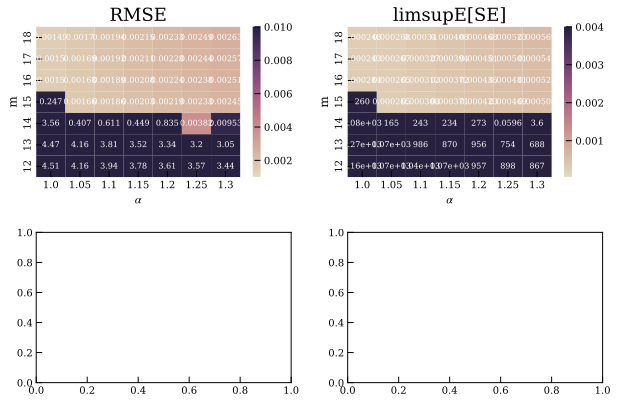

In [115]:
# ========================================
# Plot
# ========================================
plt.rcParams['text.usetex'] = False # 場当たり的な対応
import seaborn as sns
cmap = "flare" # flare_r
cmap = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True)
fig, ax = plt.subplots(2, 2, figsize=(9, 6))

# load data
df_sup_se = pd.read_csv(f"{data_dir}/sup_se.csv", index_col=0, header=0)
df_rmse = pd.read_csv(f"{data_dir}/rmse.csv", index_col=0, header=0)
df_ensdim = pd.read_csv(f"{data_dir}/ensdim.csv", index_col=0, header=0)
# df_traceP = pd.read_csv(f"{data_dir}/traceP.csv", index_col=0, header=0)

ax00 = ax[0, 1]
sns.heatmap(df_sup_se, ax=ax00, vmax=J*r**2, vmin=J*r**2/100, cmap=cmap, annot=True, fmt=".3g", annot_kws={'fontsize': 8, 'color':'white'})
ax00.set_title("limsupE[SE]")
ax00.set_ylabel("m")
ax00.set_xlabel(r"$ \alpha $")
ax00.invert_yaxis()

ax01 = ax[0, 0]
sns.heatmap(df_rmse, ax=ax01, vmax=r, vmin=r/10, cmap=cmap, annot=True, fmt=".3g", annot_kws={'fontsize': 8, 'color':'white'})
ax01.set_title("RMSE")
ax01.set_ylabel("m")
ax01.set_xlabel(r"$ \alpha $")
ax01.invert_yaxis()

# ax10 = ax[1, 0]
# sns.heatmap(df_traceP, ax=ax10, cmap=cmap, annot=True, fmt=".3g", annot_kws={'fontsize': 8, 'color':'white'})
# ax10.set_title(r"$\sqrt{trace(P^a)/J}$")
# ax10.set_ylabel("m")
# ax10.set_xlabel(r"$ \alpha $")
# ax10.invert_yaxis()

# ax11 = ax[1, 1]
# sns.heatmap(df_ensdim, ax=ax11, cmap=cmap, annot=True, fmt=".3g", annot_kws={'fontsize': 8, 'color':'white'})
# ax11.set_title("ens-dim")
# ax11.set_ylabel("m")
# ax11.set_xlabel(r"$ \alpha $")
# ax11.invert_yaxis()

fig.tight_layout()
# fig.savefig(f"{data_dir}/index.pdf")

plt.show()


# Plot RMSE and limsupE[SE] with ensemble-dim and trace(P)
# if df_rmse.shape[0] > 1 and df_rmse.shape[1] > 1:
#     fig2, ax2 = plt.subplots(1, 2, figsize=(8, 3))
#     ax21 = ax2[0]
#     cf = ax21.contourf(df_rmse.columns, df_rmse.index, df_rmse, levels=[*np.linspace(r/10, r, 50)])
#     plt.colorbar(cf)
#     cs = ax21.contour(df_rmse.columns, df_rmse.index, df_ensdim, cmap="flare_r", levels=np.arange(10, 15, 0.5))
#     ax21.clabel(cs, cs.levels[1::2])
#     ax21.set_xlabel("$ \\alpha $")
#     ax21.set_ylabel("$ m $")
#     ax21.set_title("RMSE with ensemble-dim.")

#     ax22 = ax2[1]
#     cf = ax22.contourf(df_rmse.columns, df_rmse.index, df_rmse, levels=[*np.linspace(r/10, r, 50)])
#     plt.colorbar(cf)
#     cs = ax22.contour(df_rmse.columns, df_rmse.index, df_traceP, cmap="flare_r", levels=np.linspace(r/10, r*3/10, 10))
#     ax22.clabel(cs, cs.levels[1::2])
#     ax22.set_xlabel("$ \\alpha $")
#     ax22.set_ylabel("$ m $")
#     ax22.set_title("RMSE with trace(P).")
#     fig2.tight_layout()


# if df_sup_se.shape[0] > 1 and df_sup_se.shape[1] > 1:
#     fig3, ax3 = plt.subplots(1, 2, figsize=(8, 3))
#     ax31 = ax3[0]
#     # sns.heatmap(df_sup_se, ax=ax31, vmax=J*r**2, vmin=J*r**2/10, cmap=cmap, annot=True, fmt=".3g", annot_kws={'fontsize': 8, 'color':'white'})
#     cf = ax31.contourf(df_sup_se.columns, df_sup_se.index, df_sup_se, levels=[*np.linspace(J*r**2/100, J*r**2, 50)])
#     plt.colorbar(cf)
#     cs = ax31.contour(df_sup_se.columns, df_sup_se.index, df_ensdim, cmap="flare_r", levels=np.arange(10, 15, 0.5))
#     ax31.clabel(cs, cs.levels[1::2])
#     ax31.set_xlabel("$ \\alpha $")
#     ax31.set_ylabel("$ m $")
#     ax31.set_title("limsupE[SE] with ensemble-dim.")

#     ax32 = ax3[1]
#     cf = ax32.contourf(df_sup_se.columns, df_sup_se.index, df_sup_se, levels=[*np.linspace(J*r**2/100, J*r**2, 50)])
#     plt.colorbar(cf)
#     cs = ax32.contour(df_sup_se.columns, df_sup_se.index, df_traceP, cmap="flare_r", levels=np.linspace(r/10, r*3/10, 10))
#     ax32.clabel(cs, cs.levels[1::2])
#     ax32.set_xlabel("$ \\alpha $")
#     ax32.set_ylabel("$ m $")
#     ax32.set_title("limsupE[SE] with trace(P).")
#     fig3.tight_layout()

In [116]:
# ========================================
# Load and Plot
# ========================================
# Dependency on m and alpha
if len(m_reduced_list) == 6:
    n_row, n_col = 2, 3
    fig, ax = plt.subplots(n_row, n_col, figsize=(10, 5))
    fig.subplots_adjust(wspace=0.3, hspace=0.3)

    for i in range(n_row):
        for j in range(n_col):
            idx = n_col*i + j
            if n_col == 1 and n_row == 1:
                ax1 = ax
            elif n_col == 1 or n_row == 1:
                ax1 = ax[idx]
            else:
                ax1 = ax[i, j]
            ax2 = ax1.twinx()
            alpha = alpha_list[idx]
            ax1.set_title(f"$\\alpha={alpha}$")
            # TODO: fix key after load csv
            df_sup_se[str(alpha)].plot.line(ax=ax1, marker="o", label="limsupE[SE]")
            # df_rmse[alpha].plot.line(ax=ax1, marker="o", label="RMSE")
            ax1.plot(m_reduced_list, J*r**2*np.ones_like(m_reduced_list), lw=1, c="black", ls="--", label="observation variance level J*r**2")
            
            df_ensdim[str(alpha)].plot.line(ax=ax2, marker="o", label="ensemble dimension", color="grey")
            # df_traceP[alpha].plot.line(ax=ax1, marker="o", label="trace(P)", color="black")
                
            ax1.set_ylim([J*r**2/100, 10*J*r**2])
            ax1.set_yscale("log")
            if j==0:
                ax1.set_ylabel("Error")
            if i==n_row-1:
                ax1.set_xlabel("m")

            ax2.set_ylim([5, 16]) # TODO: scale Error J*r**2 equivalent to ensemble dimension 13
            if i==0 and j==n_col-1:
                ax2.set_ylabel("ensemble dimension")
                ax1.legend(bbox_to_anchor=(1.3, 1), loc='upper left')
                ax2.legend(bbox_to_anchor=(1.3, 0.6), loc='upper left')

m=14


Text(0.5, 1.0, 'limsupE[SE] vs. $\\alpha$')

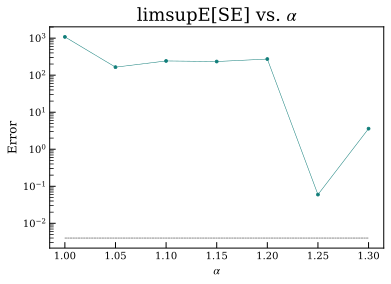

In [122]:
# ========================================
# Load and Plot
# ========================================
# Dependency on alpha
index_m = 2
print(f"m={m_reduced_list[index_m]}")
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(alpha_list, df_sup_se.iloc[index_m], marker="o")
ax.plot(alpha_list, J*r**2*np.ones_like(alpha_list), color="k", ls="--")
ax.set_yscale("log")
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel("Error")
ax.set_title("limsupE[SE] vs. $\\alpha$")

k_seed 0


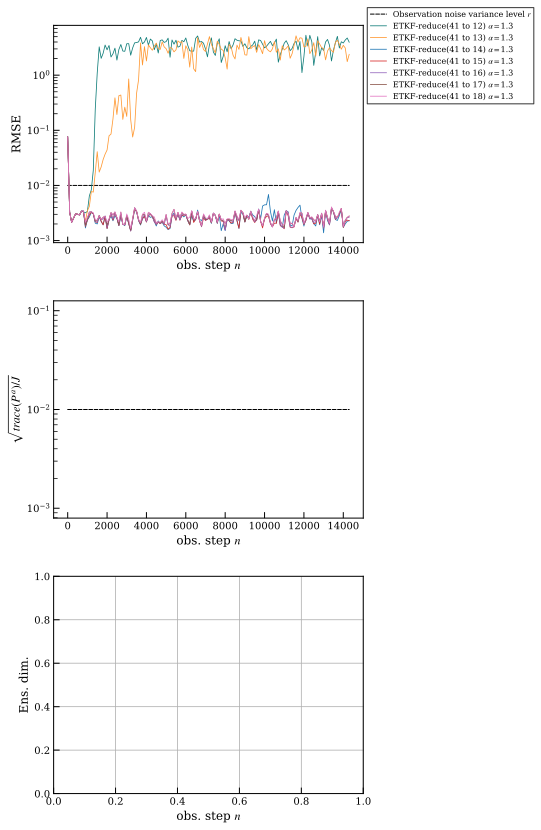

In [118]:
# ========================================
# Plot
# ========================================
# Plot time series
# Require: Xa_dict

fig, ax = plt.subplots(3, 1, figsize=(8, 12))
fig.subplots_adjust(hspace=0.1)
ax0, ax1, ax2 = ax
plot_type = "one sample" # "one sample", "all sample", "expectation"

plot_per = 100
t = np.arange(0, len(x_true))[::plot_per]

ax0.plot(t, r*np.ones_like(t), lw=1, c="black", ls="--", label="Observation noise variance level $ r $")
ax1.plot(t, r*np.ones_like(t), lw=1, c="black", ls="--")

if plot_type == "one sample":
    k_seed = 0 # seed
    print("k_seed", k_seed)
for i, m_reduced in enumerate(m_reduced_list):
    for j, alpha in enumerate(alpha_list):
        if j != 6:
            continue
        # m_reduced, alpha, _ = param_dict[i, j, 0]

        # ax0
        match plot_type:
            case "one sample":
                # plot rmse for seed k
                k = k_seed
                xa = [np.mean(X, axis=0) for X in Xa_dict[i, j, k]]
                plot_loss(x_true[::plot_per], xa[::plot_per], loss_rms, x_index=t, ax=ax0, label=f'ETKF-reduce({m0} to {m_reduced}) $ \\alpha=${alpha}', lw=0.8)
            case "all sample":
                # plot rmse samples over seeds
                for k in range(len(seeds)):
                    xa_k = [np.mean(X, axis=0) for X in Xa_dict[i, j, k]]
                    plot_loss(x_true[::plot_per], xa_k[::plot_per], loss_rms, x_index=t, ax=ax0, lw=0.3, alpha=0.5)
            case "expectation":
                # plot E[rmse]
                rmse_wt = []
                for k in range(len(seeds)):
                    xa_k = [np.mean(X, axis=0) for X in Xa_dict[i, j, k]]
                    rmse_k = np.linalg.norm(x_true-xa_k, axis=-1)/np.sqrt(J)
                    rmse_wt.append(rmse_k) # (N_seed, T)
                rmse_t = np.mean(np.array(rmse_wt), axis=0) # (T, )
                ax0.plot(t, rmse_t[::plot_per], label=f'ETKF-reduce({m0} to {m_reduced}) $ \\alpha=${alpha}', lw=0.8)
        
        # ax1
        # match plot_type:
        #     case "one sample":
        #         k = k_seed
        #         ax1.plot(t, np.sqrt(compute_traceP(Xa_dict[i, j, k])/J)[::plot_per], label=f'ETKF-reduce({m0} to {m_reduced}) $ \\alpha=${alpha}', lw=0.8)
        #     case "all sample":
        #         for k in range(len(seeds)):
        #             ax1.plot(t, np.sqrt(compute_traceP(Xa_dict[i, j, k])/J)[::plot_per], lw=0.3, alpha=0.5)
        #     case "expectation":
        #         traceP_wt = []
        #         for k in range(len(seeds)):
        #             traceP_k = np.sqrt(compute_traceP(Xa_dict[i, j, k])/J)
        #             traceP_wt.append(traceP_k)
        #         traceP_t = np.mean(np.array(traceP_wt), axis=0)
        #         ax1.plot(t, traceP_t[::plot_per], label=f'ETKF-reduce({m0} to {m_reduced}) $ \\alpha=${alpha}', lw=0.8)
        # plot_loss((H@x_true[::plot_per].T).T, y[::plot_per], loss_rms, x_index=t, ax=ax1, label='obs.', lw=0.5, color="black", ls="-")
# 
        # ax1.legend(bbox_to_anchor=(1, 1.1), loc="upper left")

        # ax2
        # match plot_type:
        #     case "one sample":
        #         k = k_seed
        #         ax2.plot(t, compute_edims(Xa_dict[i, j, k])[::plot_per], label=f'ETKF-reduce({m0} to {m_reduced}) $ \\alpha=${alpha}', lw=0.8)
        #     case "all sample":
        #         for k in range(len(seeds)):
        #             ax2.plot(t, compute_edims(Xa_dict[i, j, k])[::plot_per], lw=0.3, alpha=0.5)
        #     case "expectation":
        #         edims_wt = []
        #         for k in range(len(seeds)):
        #             edims_k = compute_edims(Xa_dict[i, j, k])
        #             edims_wt.append(edims_k)
        #         edims_t = np.mean(np.array(edims_wt), axis=0)
        #         ax2.plot(t, edims_t[::plot_per], label=f'ETKF-reduce({m0} to {m_reduced}) $ \\alpha=${alpha}', lw=0.8)
        # ax2.set_xlabel('t')
        # ax2.set_ylabel('Ens. dim.')
        # # ax2.set_ylim([10, 20])
        # ax2.set_yticks([0, 11, 13, 14, 15, 20, 30, 40])
        # # ax2.legend(bbox_to_anchor=(1, 1.1), loc="upper left")
        # # arrow_style = dict(facecolor='black', shrink=0.01, width=0.3, headlength=5, headwidth=5)
        # # print(f"reduce ensemble at {N_spinup}")

# ax0
ax0.set_xlabel('obs. step $n$')
if plot_type == "expectation":
    ax0.set_ylabel('E[RMSE]')
else:
    ax0.set_ylabel('RMSE')
ax0.legend(bbox_to_anchor=(1, 1.1), loc="upper left", fontsize=8)
ax0.set_yscale("log")
fig.tight_layout()

# ax1
ax1.set_xlabel('obs. step $n$')
ax1.set_ylabel(r'$\sqrt{trace(P^a)/J}$')
ax1.set_yscale('log')

# ax2
ax2.set_xlabel('obs. step $n$')
if plot_type == "expectation":
    ax2.set_ylabel('E[Ens. dim.]')
else:
    ax2.set_ylabel('Ens. dim.')
ax2.grid(True)


fig.tight_layout()

In [119]:
# Plot
# for i, m_reduced in enumerate(m_reduced_list):
#     plot_loss(x_true, etkf_list[i].x, loss_rms, ax=ax0, label=f'ETKF-reduce({m} to {m_reduced})', lw=0.8)
# # for i, m_reduced in enumerate(m_reduced_list):
# #     plot_loss(x_true, etkf0_list[i].x, loss_rms, ax=ax0, label=f'ETKF-{m_reduced}', lw=0.8, ls="--")
# plot_loss((H@x_true.T).T, y, loss_rms, ax=ax0, label='obs.', lw=0.5, color="k", ls="-")
# ax0.set_xlabel('t')
# ax0.set_ylabel('RMSE')
# arrow_style = dict(facecolor='black', shrink=0.01, width=0.3, headlength=5, headwidth=5)
# # ax0.annotate('', xy=(N_spinup, 1.5*r), xytext=(N_spinup, 2*r), arrowprops=arrow_style)
# # ax0.text(N_spinup-30, 2*r, 'reduce ensemble', fontdict=dict(fontsize=12))
# ax0.set_ylim([0, 2])
# ax0.legend(bbox_to_anchor=(1, 1.1), loc="upper left")
# ax0.set_yscale("log")
# fig.tight_layout()

# ax1 = ax[1]
# for i, m_reduced in enumerate(m_reduced_list):
#     ax1.plot(np.sqrt(compute_traceP(etkf_list[i].X_a)/J), label=f'ETKF-reduce({m} to {m_reduced})', lw=0.8)
# # for i, m_reduced in enumerate(m_reduced_list):
# #     ax1.plot(np.sqrt(traceP(etkf0_list[i].X_a)/J), label=f'ETKF-{m_reduced}', lw=0.8, ls="--")
# plot_loss((H@x_true.T).T, y, loss_rms, ax=ax1, label='obs.', lw=0.5, color="k", ls="-")
# ax1.set_xlabel('t')
# ax1.set_ylabel(r'$\sqrt{trace(P^a)/J}$')
# ax1.set_yscale('log')
# ax1.legend(bbox_to_anchor=(1, 1.1), loc="upper left")
# arrow_style = dict(facecolor='black', shrink=0.01, width=0.3, headlength=5, headwidth=5)

# X_a = etkf_list[-1].X_a
# print(etkf_list[-1].m)

# ax2 = ax[2]
# for i, m_reduced in enumerate(m_reduced_list):
#     ax2.plot(compute_edims(etkf_list[i].X_a), label=f'ETKF-reduce({m} to {m_reduced})', lw=0.8)
# # for i, m_reduced in enumerate(m_reduced_list):
# #     ax2.plot(compute_edims(etkf0_list[i].X_a), label=f'ETKF-{m_reduced}', lw=0.8, ls="--")
# ax2.set_xlabel('t')
# ax2.set_ylabel('Ens. dim.')
# # ax2.set_ylim([10, 20])
# ax2.set_yticks([0, 11, 13, 15, 20, 30, 40])
# ax2.legend(bbox_to_anchor=(1, 1.1), loc="upper left")
# arrow_style = dict(facecolor='black', shrink=0.01, width=0.3, headlength=5, headwidth=5)
# print(f"reduce ensemble at {N_spinup}")
# # ax.annotate('', xy=(N_spinup, 1.5*r), xytext=(N_spinup, 2*r), arrowprops=arrow_style)
# # ax.text(N_spinup-30, 2*r, 'reduce ensemble', fontdict=dict(fontsize=12))
# # ax.set_ylim([0, 2])
# # ax.set_yscale("log")
# fig.tight_layout()
# plt.grid(True)
# fig.tight_layout()

## Dependency on r (check the filter divergence)
The attractor size $ \rho $ is approximated by the time average of $ 2|x_n| $.

data/case1/r0
data/case1/r1
data/case1/r2
data/case1/r3
data/case1/r4
i_target_m = 2, n_m_reduced = 7


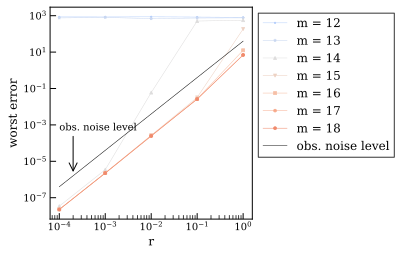

In [120]:
# ========================================
# IMPORTANT: Only for case1, 3
# ========================================
from plot import summarize_rm

data_dir_r = "data/case1"

logr_list = [0, 1, 2, 3, 4]
# logr_list = [0, 1, 2, 3]

fig, ax = summarize_rm(data_dir_r, logr_list, target_m=14)

arrowprops = dict(arrowstyle="->", edgecolor='black', facecolor='black')
ax.annotate('', xy=(2e-4, 2e-6), xytext=(2e-4, 3e-4), arrowprops=arrowprops)
ax.text(1e-4, 5e-4, 'obs. noise level', fontdict=dict(fontsize=10, color="black"))
fig.savefig(f"{data_dir_r}/sup_se_r.pdf")